<table style="background-color:#F5F5F5;" width="100%">
<tr><td style="background-color:#F5F5F5;"><img src="../images/logo.png" width="150" align='right'/></td></tr>     <tr><td>
            <h2><center>Aprendizagem Automática em Engenharia Biomédica</center></h2>
            <h3><center>1st Semester - 2025/2026</center></h3>
            <h4><center>Universidade Nova de Lisboa - Faculdade de Ciências e Tecnologia</center></h4>
</td></tr>
    <tr><td><h2><b><center>Lab 7 - Model Optimization: Cross Validation and Hyperparameter Tuning</center></b></h2>
    <h4><i><b><center>Human Activity Recognition with Decision Trees</center></b></i></h4></td></tr>
</table>

## 1. Introduction to Optimizing Machine Learning Models

In machine learning, building a predictive model is only the first step toward solving a real-world problem. To ensure the model performs well in practice, it is essential to optimize it by finding the best combination of model parameters and structure. This process of __model optimization__ helps us enhance a model's ability to generalize, meaning it performs well on new, unseen data.

### 1.1 The Importance of Model Optimization

Model optimization allows us to achieve three key goals:

* __Generalization__: A well-optimized model should generalize effectively across various datasets. Generalization refers to the model’s ability to perform well not just on the training data but also on new data it hasn't seen before.
* __Model Selection__: Optimization allows us to systematically compare different models and select the one that performs best for the task at hand.
* __Avoiding Overfitting and Underfitting__:
    * __Overfitting__: occurs when a model learns the noise in the training data instead of the underlying patterns. This results in high performance on training data but poor performance on new data.
    * __Underfitting__: happens when the model is too simple to capture the patterns in the data, resulting in low performance on both training and testing data.

### 1.2 Goal of Today's Class

In today's practical lession we are going to use two specific strategies that can be employed for model optimization. These are

* __Cross Validation__: a technique for assessing a model's performance on different substes of the data.
* __Hyperparemeter Tuning__: a technique to adapt the model's external parameters to improve the data fit.

Together, cross validation and hyperparameter tuning form a powerful toolkit for model optimization. Cross validation ensures that the model is robust and generalizes well, while hyperparameter tuning tailors the model’s complexity and behavior to the data, enhancing its overall performance.

### 1.3 Revisiting the UCI Human Activity Recognition Dataset

As always, to train models we need data. To simplify things, we will use the same dataset that we used in the previous lesson: [__the UCI Human Activity Recognition Using Smartphones Dataset__](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones).

The code below loads the data, windows it, and extracts features the same way we did in the previous class, __with the exception that the window_splitter() function also retrieves the subject_id for the corresponding window__.

In [1]:
# -- imports needed for the Notebook -- #

%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Union, Any, Dict

In [ ]:
#---------------------------------------------------------------------#
# --- ONLY RUN THIS CODE IF YOU HAVEN'T DOWNLOADED THE DATASET YET ---#
#---------------------------------------------------------------------#
# -- Download dataset from UCI repo -- #

# check if dataset was already downloaded before
if not os.path.exists("Data/UCI HAR Dataset.zip"):

    # define the url where the .zip file of the dataset is stored
    url = 'https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip'

    # download the dataset
    wget.download(url, out="Data/UCI HAR Dataset_outer.zip")

# check if the outer zip file still exists (just in case that this code is run multiple times)
if os.path.exists("Data/UCI HAR Dataset_outer.zip"):
    # Unzip the outer folder
    with zipfile.ZipFile("Data/UCI HAR Dataset_outer.zip", 'r') as outer_zip:
        outer_zip.extractall("Data")

    # remove the original zipfile and unnecessary files
    os.remove("Data/UCI HAR Dataset_outer.zip")
    os.remove("Data/UCI HAR Dataset.names")

# unzip the actual dataset
with zipfile.ZipFile("Data/UCI HAR Dataset.zip", 'r') as data_zip:
    data_zip.extractall("Data")

In [2]:
def get_inertial_data(acc_axis: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads and processes the inertial signal data from the UCI Human Activity Recognition (HAR) dataset.

    This function reads accelerometer data for a specified axis (e.g., 'x', 'y', or 'z') for both 
    the training and test datasets. It also loads corresponding activity labels and subject IDs. 
    The data is windowed and repeated 64 times to match the window size.

    :param acc_axis: The axis of accelerometer data to load ('x', 'y', or 'z').

    :returns: 
        - X_train: Training set accelerometer data (horizontally stacked).
        - y_train: Repeated activity labels for the training set.
        - subject_train: Repeated subject IDs for the training set.
        - X_test: Test set accelerometer data (windowed and stacked horizontally).
        - y_test: Repeated activity labels for the test set.
        - subject_test: Repeated subject IDs for the test set.
        - activity_labels: Array of activity labels for both training and test sets.

    :rtype: Tuple of NumPy arrays containing processed data.
    """
    # --- loading training data --- #
    # Load training accelerometer data for the specified axis
    X_train = np.loadtxt('Data/UCI HAR Dataset/train/Inertial Signals/total_{}_train.txt'.format(acc_axis))

    # stack all data horizontally to obtain a 1D array
    X_train = np.hstack([window[:64] for window in X_train])
    
    # Load activity labels for training data
    y_train = np.loadtxt('Data/UCI HAR Dataset/train/y_train.txt', dtype=int)

    # repeat 64 times to have a label for each training data sample
    y_train = np.repeat(y_train, 64)
    
    # Load subject IDs for training data
    subject_train = np.loadtxt('Data/UCI HAR Dataset/train/subject_train.txt', dtype=int)

    # repeat 64 times to have a subject ID for each training data sample
    subject_train = np.repeat(subject_train, 64)

    # --- loading testing data --- #
    # Load test accelerometer data for the specified axis
    X_test = np.loadtxt('Data/UCI HAR Dataset/test/Inertial Signals/total_{}_test.txt'.format(acc_axis))

    # stack all data horizontally to obtain a 1D array
    X_test = np.hstack([window[:64] for window in X_test])
    
    # Load activity labels for test data
    y_test = np.loadtxt('Data/UCI HAR Dataset/test/y_test.txt', dtype=int)

    # repeat 64 times to have a label for each testing data sample
    y_test = np.repeat(y_test, 64)
    
    # Load subject IDs for test data
    subject_test = np.loadtxt('Data/UCI HAR Dataset/test/subject_test.txt', dtype=int)

    # repeat 64 times to have a subject ID for each training data sample
    subject_test = np.repeat(subject_test, 64)
    
    # Load activity labels (activity number and corresponding activity name)
    activity_labels = pd.read_csv('Data/UCI HAR Dataset/activity_labels.txt', 
                                  index_col=0, header=None, sep=' ')
    
    # Return all the processed data
    return (X_train, y_train, subject_train, X_test, y_test, subject_test, np.hstack(activity_labels.values))

In [3]:
def window_splitter(acc: np.ndarray, labels: np.ndarray, 
                    subject_ids: np.ndarray, window_size: int, fs: int) -> Tuple[List[np.ndarray], List[int], List[int]]:
    """
    Splits time-series data into non-overlapping windows and assigns labels to each window. Only windows containing a unique label are returned.
    
    :param acc: np.ndarray
        Time-series acceleration data of shape (n_samples,).
    :param labels: np.ndarray
        Array of labels corresponding to each time step in `acc`, with shape (n_samples,).
    :param labels: np.ndarray
        Array of containing the subject ID corresponding to each time step in `acc`, with shape (n_samples,).
    :param window_size: int
        Desired window length in seconds.
    :param fs: int
        Sampling frequency in Hz, used to convert `window_size` to samples.
        
    :returns: Tuple[List[np.ndarray], List[int]]
        A tuple containing:
        - List containing the extracted windows. The list is of shape (n_windows, samples_per_window).
        - List containing the labels assigned to each window.
        - numpy.ndarray containing the subject ID for each window.
    """
    
    # Input validation
    if window_size <= 0 or fs <= 0:
        raise ValueError("Both `window_size` and `fs` must be positive integers.")
    if acc.shape[0] != labels.shape[0]:
        raise ValueError("The `acc` and `labels` arrays must have the same length along the first dimension.")
    
    # Convert window size from seconds to samples
    window_size_samples = window_size * fs
    
    # Initialize lists to hold windows and corresponding labels
    X_windows = []
    y_windows = []
    subject_id_windows = []

    # Sliding window approach
    for w_start in range(0, len(acc) - window_size_samples + 1, window_size_samples):
        current_window_labels = labels[w_start:w_start + window_size_samples]
        
        # Check if the window contains only a single label
        unique_labels = np.unique(current_window_labels)

        # check if the window only contains one unique label (i.e., the entire window contains only data from one activity)
        if len(unique_labels) == 1:

            # add the windows to the list
            y_windows.append(unique_labels[0])
            X_windows.append(acc[w_start:w_start + window_size_samples])
            subject_id_windows.append(subject_ids[w_start])

    return X_windows, y_windows, np.asarray(subject_id_windows)


In [4]:
def compute_statistical_features(X_windows: Union[np.ndarray, list]) -> np.ndarray:
    """
    Computes statistical features (mean, maximum, minimum) for each window in a time-series dataset.
    
    :param X_windows: Union[np.ndarray, list]
        A 2D array or list containing the extracted windows containing the accelerometer data. The list is of shape (number_of_windows, samples_per_window).
        
    :returns: np.ndarray
        A 2D array of shape (n_windows, 3), where each row contains the mean, max, and min of each window.
        
    :raises ValueError: If `X_windows` is not a 2D array or list, or if it has less than 2 columns.
    """
    
    # Convert input to numpy array if it's a list
    X_windows = np.asarray(X_windows)
    
    # Input validation
    if X_windows.ndim != 2:
        raise ValueError("Input `X_windows` must be a 2D array or list of shape (n_windows, n_features).")
    if X_windows.shape[1] < 1:
        raise ValueError("Each window in `X_windows` must contain at least one feature.")
    
    # Compute statistical features for each window
    mean_feat = np.mean(X_windows, axis=1)  # Mean of each window
    max_feat = np.max(X_windows, axis=1)    # Maximum of each window
    min_feat = np.min(X_windows, axis=1)    # Minimum of each window
    
    # Stack features column-wise to form the output array
    statistical_features = np.column_stack((mean_feat, max_feat, min_feat))
    
    return statistical_features

In [5]:
# -- loading, windowing, and feature extraction -- #

# define sampling frequency and window size as constants
FS = 50
W_SECONDS = 5

# (1) load the data
train_data, train_labels, subjects_train, test_data, test_labels, subjects_test, activity_labels = get_inertial_data('acc_x')

# print out some information on the loaded data
print("ACC train data shape: {} | target shape: {} | Subjects: {}".format(train_data.shape, train_labels.shape, np.unique(subjects_train).size))
print("ACC test  data shape: {} | target shape: {} | Subjects: {}".format(test_data.shape, test_labels.shape, np.unique(subjects_test).size))
print("\nAvailable Activities:\n{}".format(activity_labels))

# (2) window the training and the test data
train_windows, y_train, subject_ids_train = window_splitter(train_data, train_labels, subjects_train, W_SECONDS, FS)
test_windows, y_test, subject_ids_test = window_splitter(test_data, test_labels, subjects_test, W_SECONDS, FS)

# (3) compute statistical features on the training and test data
X_train = compute_statistical_features(train_windows)
X_test = compute_statistical_features(test_windows)

# printing the first 10 rows of the training data
print("\nThe first 10 rows of the training data: \n{}".format(X_train[:10]))

ACC train data shape: (470528,) | target shape: (470528,) | Subjects: 21
ACC test  data shape: (188608,) | target shape: (188608,) | Subjects: 9

Available Activities:
['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING']

The first 10 rows of the training data: 
[[1.01958714 1.027664   1.009013  ]
 [1.02032754 1.026194   1.013645  ]
 [1.02092431 1.02821    1.01161   ]
 [1.01553708 1.025468   0.9974581 ]
 [1.00990811 1.015505   1.002174  ]
 [1.0097102  1.015896   1.003571  ]
 [0.92792139 0.9403026  0.90814   ]
 [0.80211137 1.069117   0.6960658 ]
 [0.82745595 0.968194   0.7706567 ]
 [0.95521952 0.9630642  0.9459184 ]]


## 2. Cross Validation

To ensure our model generalizes well and isn’t overfitted to training data, we need more than just performance metrics.

When we use a single train-test split to compare models, we risk choosing the model with the best test performance by chance, leading to a biased evaluation. This approach can compromise the impartiality of our test set.

One strategy to avoid this problem is to apply __Cross Validation (CV)__ while training. This process essentially consists on training a model multiple times, with different training sets, to evaluate if its performance is robust to slight variations. This means that we are essentially seperating our training dataset into several subsets consisiting of training and validation sets.

<div>
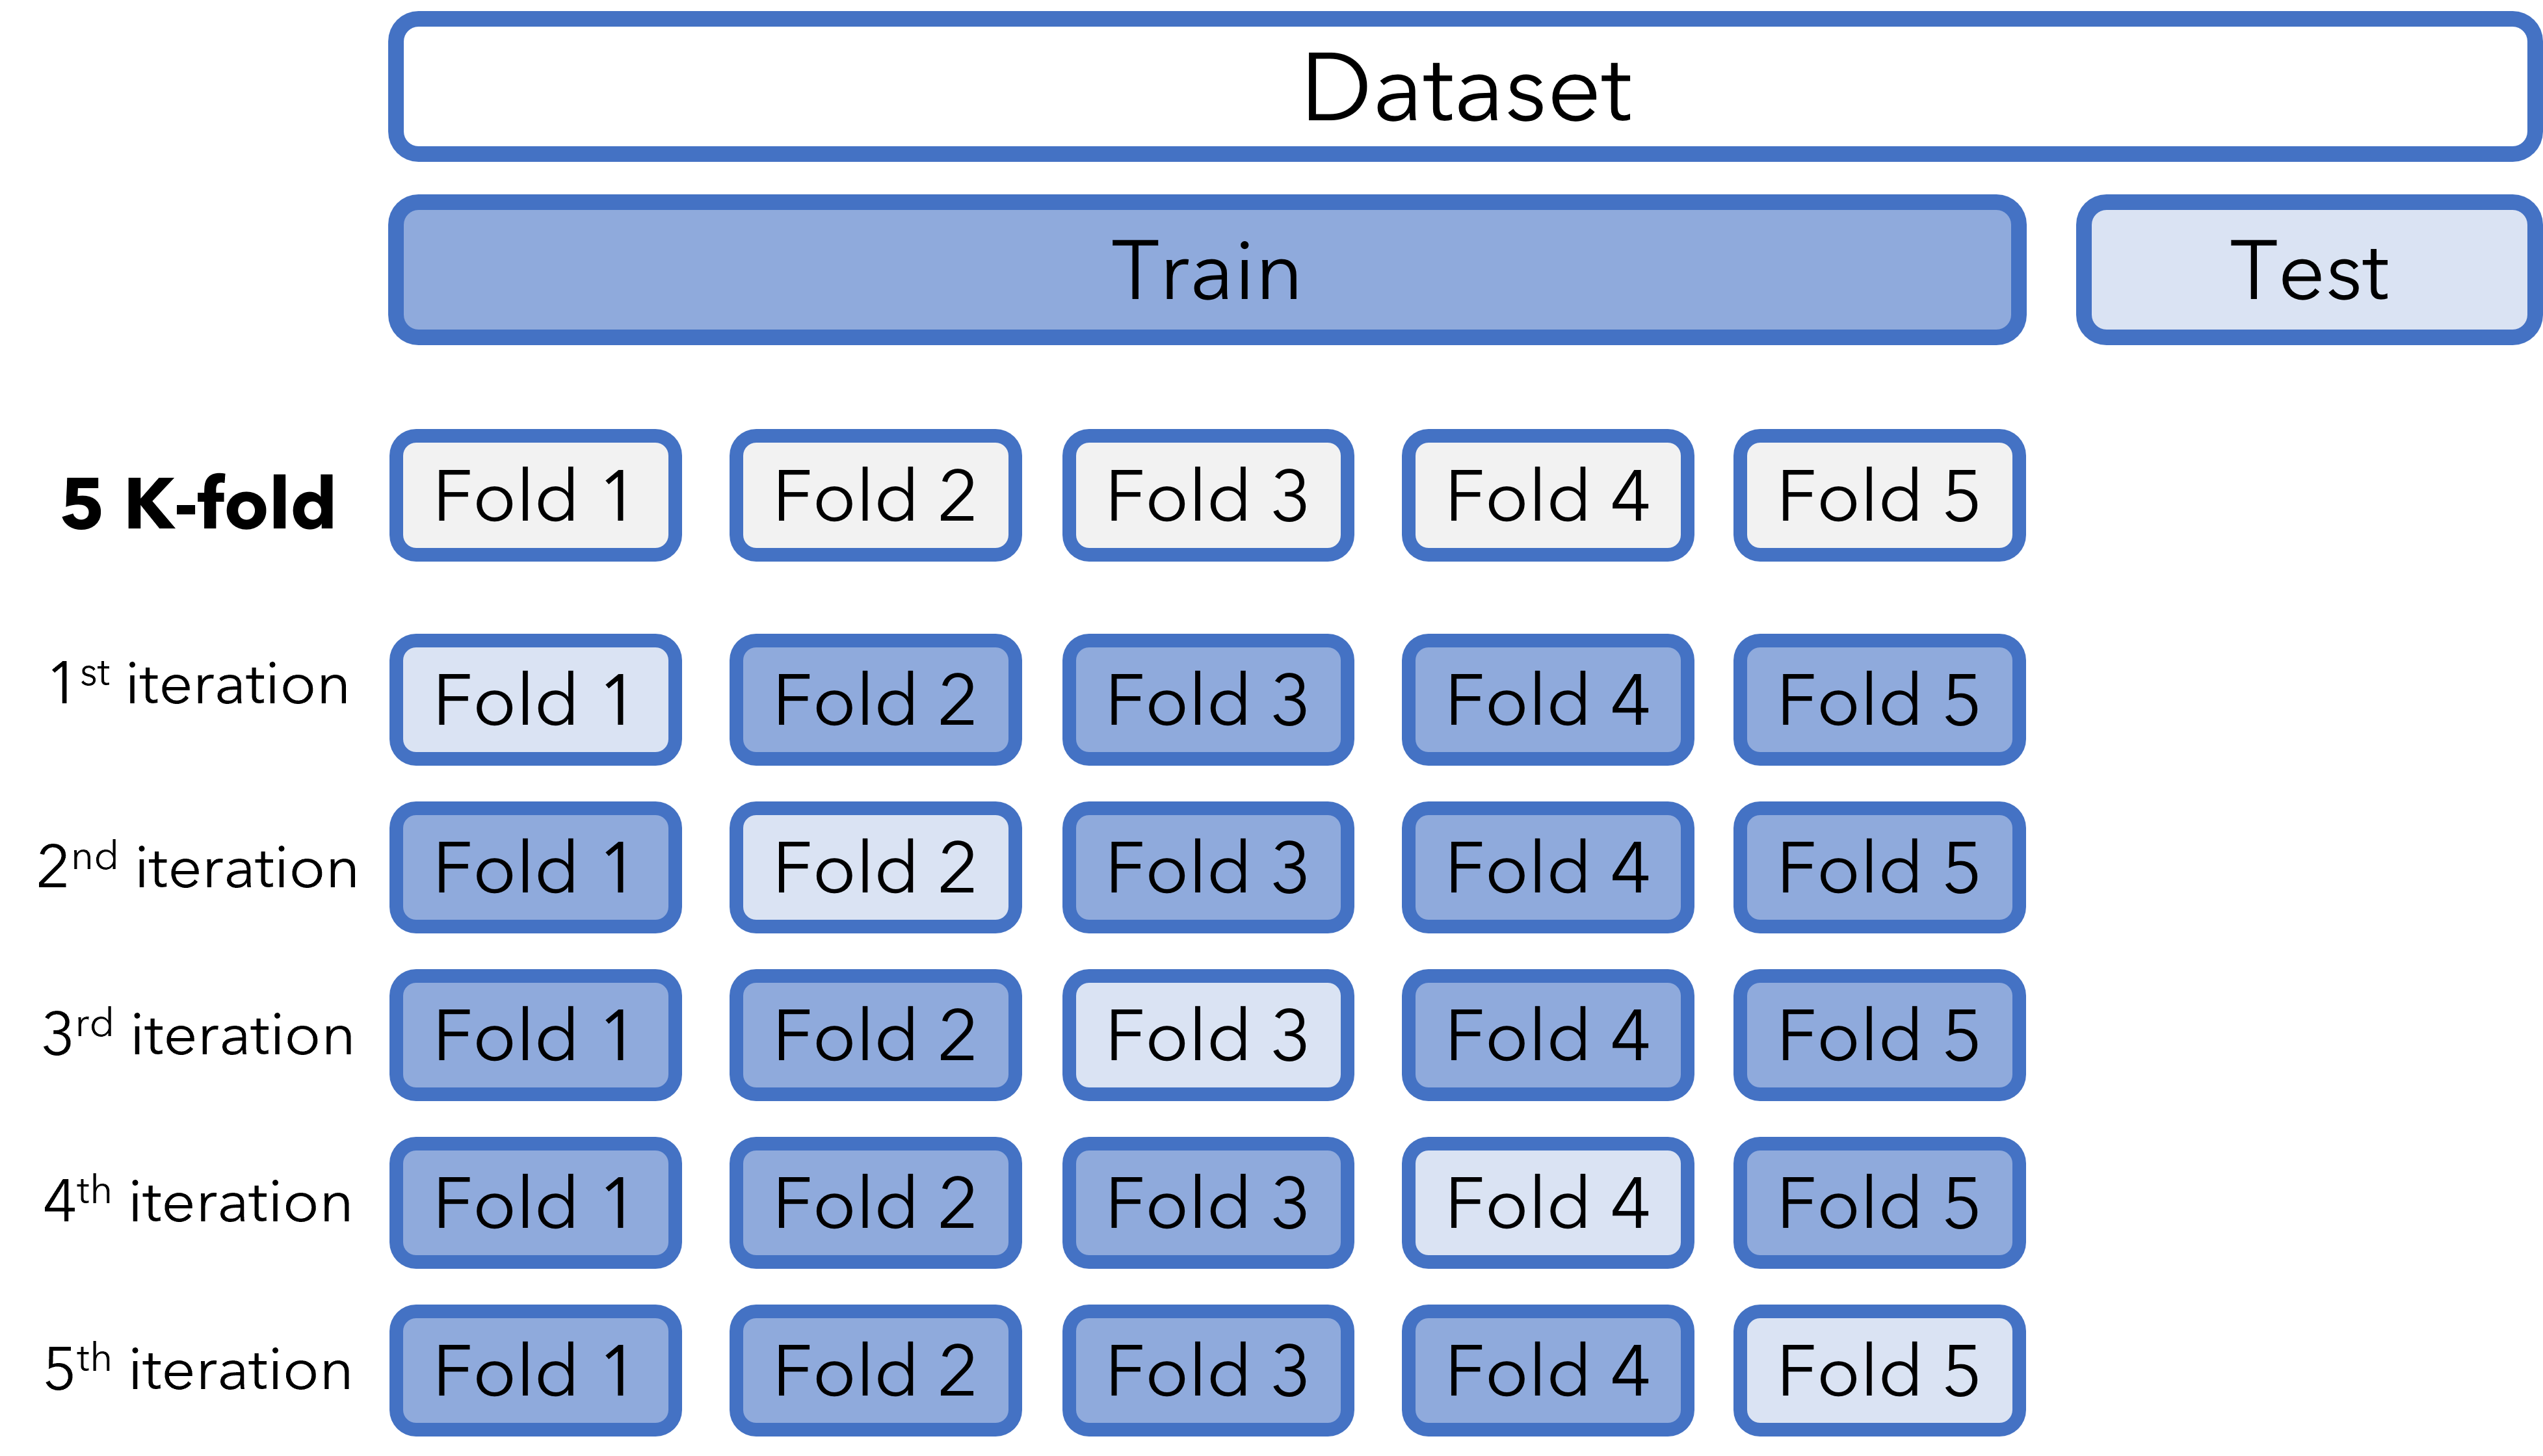
</div>

### 2.1 Purpose of Cross Validation

CV allows us to:

* __Improve Reliability__: By using multiple splits, cross validation provides a more reliable estimate of a model’s performance.
* __Select Models and Parameters__: CV enables us to compare various models or configurations systematically to choose the most suitable one.
* __Prevent Overfitting and Underfitting__: Since CV evaluates the model across multiple subsets, it reduces the risk of tuning our model to a single train-test split, leading to better generalization.

### 2.2 Types of Cross Validation
There are different strategies one can adopt. Each of these methods offers distinct advantages depending on the dataset structure and the specific goals of the model evaluation. Understanding which cross validation approach to apply helps ensure a more reliable model performance estimate, building a foundation for effective hyperparameter tuning in the following steps. The list below presents some CV techniques. The list does not prentend to be complete.

__1. K-Fold Cross Validation__:

* __Overview__: The dataset is divided into K equally-sized “folds.” The model trains on K-1 folds and tests on the remaining fold. This process is repeated K times, with each fold serving as the test set once. The final performance is the average of all K test results.
* __Use Case__: K-Fold CV is widely used in general machine learning problems, offering a balanced trade-off between computational efficiency and reliable performance estimation.
* __sklearn function__: [__KFold()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

__2. Stratified K-Fold Cross Validation__:

* __Overview__: Similar to K-Fold CV, but ensures that each fold has approximately the same proportion of each class as the entire dataset. This is particularly useful for classification problems with imbalanced classes.
* __Use Case__: Preferred for classification tasks where maintaining class balance in each fold is essential for fair evaluation.
* __sklearn function__: [__StratifiedKFold()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

__3. Leave-One-Out Cross Validation (LOOCV)__:

* __Overview__: Each data point acts as a single test set, with all other data points used for training. The process is repeated for each data point, making LOOCV computationally expensive but providing a very fine-grained performance estimate.
* __Use Case__: Best suited for small datasets where having a robust estimate of model performance is crucial.
* __sklearn function__: [__LeaveOneOut()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut)

__4. Shuffled Cross Validation__:

* __Overview__: This approach involves randomly shuffling the dataset, then splitting it into training and testing subsets. This process is repeated multiple times, with a new shuffle each time. Unlike K-Fold, Shuffled CV doesn’t ensure equal-sized splits or folds but allows flexibility in the size of train-test splits.
* __Use Case__: Shuffled CV is helpful when a specific proportion (e.g., 70% train, 30% test) is preferred, offering a broader view of model performance across multiple random partitions.
* __sklearn function__: [__ShuffleSplit()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit)

__5. TimeSeriesSplit__:
* __Overview__: Designed specifically for time-series data, this method splits the data based on a sequence, maintaining the temporal order. Each fold trains on an earlier segment of the data and tests on a later segment, reflecting a realistic forecasting scenario.
* __Use Case__: Ideal for time-series forecasting or sequential data where the order of data points matters.
* __sklearn function__: [__TimeSeriesSplit()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

__6. GroupKFold__:

* __Overview__: In situations where data points are grouped by a common identifier (e.g., data from the same subject or experiment), GroupKFold ensures that all data points from a particular group are kept together within either the training or test set. This avoids data leakage from having related data points in both the training and test sets. GroupKFold is a variation of K-Fold Cross Validation specifically for grouped data. This approach is similar to K-Fold but ensures that groups are not split across folds.
* __Use Case__: Ideal for datasets with identifiable groupings, such as repeated measurements from the same subjects or multiple instances from similar sources. GroupKFold provides a reliable performance estimate while respecting group structures, making it a common choice in healthcare, behavioral, and customer studies where data points within groups may be highly correlated.
* __sklearn function__: [__GroupKFold()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html)

### 2.2 Applying Simple Cross Validation Using Scikit-learn

Scikit-learn provides several convenience functions to simplify the implementation of cross-validation in machine learning workflows. These functions allow us to efficiently assess model performance without manually coding the cross-validation logic. By leveraging these built-in utilities, we can focus on model development while ensuring robust evaluation through established cross-validation techniques.

__1. cross_val_score__:
* __Overview__: the cross_val_score function provides a simple and efficient way to evaluate a model's performance through cross-validation using the accuracy of the model as the evaluation metric. By default, it uses K-Fold cross-validation, but it is also possible to define any of the above-mentioned CV techniques and pass it to the function by using the `cv` parameter.
* __Use Case__: cross_val_score is particularly useful when you want a quick assessment of a model's performance across different subsets of data without the need for complex validation loops. It allows you to easily calculate the average score and standard deviation of the model’s performance, providing insights into its stability and reliability. This function is suitable for scenarios where you need to compare different models or configurations using a straightforward accuracy metric or any other scoring metric specified by the user.
* __sklearn function__: [__cross_val_score()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

__2. cross_validate__:
* __Overview__: the cross_validate function extends the capabilities of cross_val_score by allowing the computation of multiple evaluation metrics in a single call. It also returns detailed information about the training and validation scores, enabling a comprehensive analysis of model performance.
* __Use Case__: cross_validate is beneficial when you want to evaluate a model based on various performance metrics (e.g., accuracy, F1 score, recall) simultaneously. This function is particularly useful in complex modeling scenarios where understanding different aspects of model performance is critical. It is a good choice when you require detailed insights, such as training times and the ability to analyze multiple metrics, to guide your model selection and tuning process.
* __sklearn function__: [__cross_validate()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)


__Exercise 1__:  
Before we can apply CV techniques, we need to prepare some models to compare them to each other. To the models it is convenient to keep them together in a single data structure, which can be a list of tuples containing the model name and the corresponding model.

__Tasks__:
* Create a list, named __models__, containing a tuple consisitng of the __name of the classifier__ and an  __instance of the classifier__ itself.
* From [sklearn supervised learning algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) select at least one classifier from each of the following groups: 
1. Support Vector Machines
2. Nearest Neighbors
3. Naive Bayes
4. Decision Trees
5. Ensemble methods

Example: `models = [("DecisionTree", DecisionTreeClassifier()), ("Clf name", clf() )]`

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# init list for holding the model tuples
models = []

# append the model tuples to the list (example on how to add the first model)
models.append(("DecisionTree", DecisionTreeClassifier()))


__Exercise 2__: 

Now that we have defined the models that we are going to use, we need to write a function that performs the training and evaluation steps for us. This function can then be used in a for-loop and in each iteration we pass one of the defined models to the function. By writing these types of abtsracted fucntions we can write an efficent ML pipeline.

__Tasks__:
* Implement a function that performs training and evaluation of a model.
* The function should be called: __train_and_evaluation__.
* The function should have the following inputs:
    >* __model__: the tuple containng the model name and the instance of the model | Type: Tuple[str, Any]
    >* __X_train__: training features as a numpy array | Type: np.ndarray
    >* __y_train__: training labels as a numpy array | Type: np.ndarray
    >* __X_test__: test features as numpy array | Type: np.ndarray
    >* __y_test__: test labels as numpy array | Type: np.ndarray
* The function should output:
    >* __metrics__: a dictionary containing the following keys (with their corresponding values)   
    >  '_Model_': the name of the model  
    >  '_Train ACC_': the accuracy on the entire training set  
    >  '_Test ACC_': the accuracy on the test set  
    >  '_K-fold ACC mean_': the mean accuracy over all folds  
    >  '_K-fold ACC std_': the standard deviation of the accuracy over all folds  
* Use the [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function with a K-fold of 10

__Hints__:
* For using a K-Fold of 10 you just have to set the parameter `cv=10`.
* The cross_val_score() function returns an numpy.ndarray containing the accuracy for each fold.
* All scikit-learn models have a `.score(X, y)` function that calculates the accuracy of the model with respect to the provided X and y. This way you do not have to use the accuracy_score() function. The `.score(X, y)` should be used after the model has been trained.

In [ ]:
from sklearn.model_selection import cross_val_score

def train_and_evaluation(model: Tuple[str, Any], X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
    """
    Train and evaluate a machine learning model using training and test datasets.

    This function fits the model to the training data, makes predictions on both 
    the training and test sets, and performs cross-validation to assess model performance.

    :param model: A tuple containing the model name as a string and the model instance.
    :param X_train: Training features as a numpy array.
    :param y_train: Training labels as a numpy array.
    :param X_test: Test features as a numpy array.
    :param y_test: Test labels as a numpy array.
    :return: A dictionary containing training score, test score, 
             and cross-validation metrics (mean and standard deviation of accuracy).
    """
    
    # get the model name and the model instance
    
    
    # Train the model on the training data
    

    # calculate the accurcay on the training and test sets using the .score() method
    
    
    # Perform cross-validation and compute accuracy scores
    
    
    # Create a dictionary to summarize the performance metrics
    metrics = {
        'Model': model_name,                    # Model name
        'Train ACC': train_acc,                 # Training accuracy
        'Test ACC': test_acc,                   # Test accuracy
        'K-fold ACC mean': np.mean(acc_cv),     # Mean accuracy from cross-validation
        'K-fold ACC std': np.std(acc_cv)        # Standard deviation of cross-validation accuracy
    }
    
    return metrics

__Exercise 3__: 

Now, it is time to put your function to work.

__Tasks__:

* Use the previous function to train and evaluate the classifiers from __Exercise 1__.
* Collect all results in a list.
* Transform that list into pandas.DataFrame.
* Set "Model" as the index of the pandas.DataFrame.
* Print the DataFrame.

In [ ]:
# list for holding the results of each model
model_metrics = []

# cycle over the models contained in the models list (for loop)

### 2.3 Implementing a GroupKFold in Scikit-learn

While the K-Fold strategy shown above works well when all training instances are independent, it’s not ideal for the HAR dataset, where this assumption doesn’t hold. In the HAR dataset:

* Data from each subject has a temporal dependency (i.e., each activity recording is ordered in time).
* Data from different subjects is independent (one subject's data has no influence on another's).
  
Because of these properties, __each subject’s data should be treated as a distinct group__. This means that when implementing a cross-validation strategy for the HAR classification task, we need to ensure that each fold contains data from entire subjects, not partial data, to prevent data leakage and ensure a realistic evaluation. By grouping data this way, we respect the natural structure of the dataset and achieve a more reliable assessment of model performance.

Therefore, we will use the [__GroupKFold()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) strategy to split our data into 10 folds. We will only apply this process to the train set with the statistical features, while the original test set will be left for evaluation. Let's see how it works. 

In [7]:
from sklearn.model_selection import GroupKFold

# intialize the GroupKFold using 10 splits
group_kfold = GroupKFold(n_splits=10)

# check how many splits were established by the CV strategy (not really necessary this is just to show how to retrieve this information)
print("The GroupKFold was set to have {} splits".format(group_kfold.get_n_splits(X_train, y_train, subject_ids_train)))

# see how the subjects were distributed for each fold
for fold, (train_index, val_index) in enumerate(group_kfold.split(X_train, y_train, subject_ids_train), start=1):

    # print the subjects used for training and testing
    print("Subjects for training: {} | Subjects for testing: {}"
          .format(np.unique(subject_ids_train[train_index]), np.unique(subject_ids_train[val_index])))

The GroupKFold was set to have 10 splits
Subjects for training: [ 1  3  6  7  8 11 14 15 16 17 19 21 22 23 26 27 28 29 30] | Subjects for testing: [ 5 25]
Subjects for training: [ 1  3  5  6  8 11 14 15 16 17 19 22 23 25 26 27 28 29 30] | Subjects for testing: [ 7 21]
Subjects for training: [ 1  3  5  6  7 11 14 15 16 17 19 21 23 25 27 28 29 30] | Subjects for testing: [ 8 22 26]
Subjects for training: [ 1  3  5  6  7  8 14 15 16 17 19 21 22 23 25 26 28 29 30] | Subjects for testing: [11 27]
Subjects for training: [ 1  3  5  6  7  8 11 14 16 17 19 21 22 23 25 26 27 28 29] | Subjects for testing: [15 30]
Subjects for training: [ 1  3  5  7  8 11 14 15 16 17 19 21 22 23 25 26 27 29 30] | Subjects for testing: [ 6 28]
Subjects for training: [ 1  3  5  6  7  8 11 15 17 19 21 22 23 25 26 27 28 29 30] | Subjects for testing: [14 16]
Subjects for training: [ 3  5  6  7  8 11 14 15 16 17 19 21 22 25 26 27 28 29 30] | Subjects for testing: [ 1 23]
Subjects for training: [ 1  5  6  7  8 11 14 15

### 3. Hyperparameter Optimization

Hyperparameter optimization is the process of systematically searching for the best hyperparameters to improve a model’s performance. Hyperparameters are parameters set before the learning process begins, controlling aspects like model complexity and training behavior. Unlike model parameters (e.g., weights in a neural network), hyperparameters do not directly interact with the data during training, so they need to be tuned manually or through automated methods.

Selecting the optimal hyperparameters can greatly impact a model's effectiveness, balancing the trade-off between bias and variance to prevent underfitting and overfitting.

### 3.1. Purpose of Hyperparameter Optimization

Hyperparameter optimization is essential because:

* __Improves Model Performance__: Finding the optimal configuration helps maximize the model’s predictive accuracy.
* __Prevents Overfitting/Underfitting__: Tuning hyperparameters helps the model generalize better on unseen data, finding the right balance between bias and variance.
* __Efficient Resource Usage__: Optimization techniques allow us to find good settings without an exhaustive search, saving time and computational resources.

### 3.2 Hyperparameter Optimization Methods

There are several popular methods for hyperparameter optimization, each with unique strategies to explore the parameter space. Here, we cover three widely-used approaches: Grid Search, Random Search, and Bayesian Search.

__1. Grid Search__:
* __Overview__: Grid Search is an exhaustive search method that tries every possible combination of specified hyperparameter values. For each combination, cross-validation is performed to evaluate model performance, and the best configuration is selected.
* __Advantages__: Provides a thorough exploration of the hyperparameter space, ensuring that all combinations are tested.
* __Disadvantages__: Computationally expensive, especially for large parameter spaces. Often impractical when the number of hyperparameters or their ranges is large.
* __Use Case__: Useful when you have a relatively small number of hyperparameters or can limit each parameter to a small set of values.
* __sklearn function__: [__GridSearchCV()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

__2. Random Search__:
* __Overview__: Instead of trying all combinations, Random Search randomly samples a specified number of hyperparameter configurations from the search space. This approach is faster than Grid Search as it explores fewer combinations, yet it can still yield high-performing models.
* __Advantages__: More efficient than Grid Search, as it focuses on sampling a diverse range of configurations rather than every possible combination.
* __Disadvantages__: There’s no guarantee of finding the absolute best combination, as some configurations may be missed.
* __Use Case__: Ideal for optimizing models with many hyperparameters or when each model evaluation is time-consuming, such as deep learning tasks or complex ML pipelines.
* __sklearn function__: [__RandomizedSearchCV()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

__3. Bayesian Optimization__:
* __Overview__: Bayesian Optimization is a probabilistic model-based approach that builds a surrogate model to predict the performance of various hyperparameter combinations. It iteratively refines this model to focus the search on promising areas of the parameter space.
* __Advantages__: Efficient for high-dimensional search spaces, as it focuses the search on likely optimal regions instead of covering the entire space. Reduces the number of evaluations required.
* __Disadvantages__: Requires more setup and computational complexity than Grid or Random Search but generally achieves better results in fewer iterations.
* __Use Case__: Effective when the search space is large or when certain hyperparameters have little impact on performance, allowing Random Search to efficiently cover a wide variety of configurations.
* __sklearn function__: [__BayesSearchCV()__](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

### 3.3 Choosing an Optimization Method
The choice of optimization method depends on factors like the complexity of the model, the number of hyperparameters, and the available computational resources. For simpler models or smaller search spaces, Grid Search or Random Search may be sufficient. However, for larger or more complex search spaces, Bayesian Optimization provides a more efficient, data-driven approach.

Hyperparameter optimization is a powerful tool in model tuning, allowing us to maximize performance by systematically searching for the best configuration of settings. In the following exercises, we will explore how to apply these techniques to improve the accuracy and generalization of our models.


### 3.4 Implementing Random Search using Scikit-learn

To understand how these type of optimization methods work, we will optimize the hyperparameters of the decision tree model using a random search strategy. As crossvalidation, the previous GroupKFold will be used.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# set the random state
rand_state = 42

# set the number of iteration for Randomized Search
iterations = 100

# define the model
dt_clf = DecisionTreeClassifier(random_state=42)

# get the iterator object containing the groupf folds
group_folds = group_kfold.split(X_train, y_train, subject_ids_train)

# set the parameter grid that we want to explore (this grid defines for each hyperparameter a set of possible values)
# the param grid has to be defined as a dict and the keys need to correspond to the hyperparameters of the model you want to optimize
param_grid = {
    'criterion': ['gini', 'entropy'],
    "max_depth": range(2, 6),
    'min_samples_split': [50, 100, 200],
    "min_samples_leaf": [25, 50, 100],
    "max_leaf_nodes": [10, 20, 30]
}

# perform RandomizedSearch optimization
# refit=True will refit a model using the best parameters found
optimized_dt_clf = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_grid, cv=group_folds, 
                                      scoring='accuracy', verbose=2, n_iter=iterations, random_state=rand_state, refit=True)

After having defined the optimization method, it is necessary to use the `fit()` method to optimize the hyperparameters. Doing this will train and evaluate all the models (with their different hyperparameters) on the respective folds. 

In [9]:
# fit all models contained in the optimization pipeline
optimized_dt_clf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, min_samples_split=50; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_leaf_nodes=20, min_samples_leaf=50, 

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001C339C718B0>,
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 6),
                                        'max_leaf_nodes': [10, 20, 30],
                                        'min_samples_leaf': [25, 50, 100],
                                        'min_samples_split': [50, 100, 200]},
                   random_state=42, scoring='accuracy', verbose=2)

In [10]:
# get the score of the best model
# the best_score is the mean accuracy over all folds
print("The best score/accuracy is: {}".format(optimized_dt_clf.best_score_))

The best score/accuracy is: 0.7339557270960961


In [11]:
# display the parameters of the best estimator
print("The best model, together with its hyperparameter settings, is: \n{}".format(optimized_dt_clf.best_estimator_))

The best model, together with its hyperparameter settings, is: 
DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=30,
                       min_samples_leaf=100, min_samples_split=50,
                       random_state=42)


In [12]:
# show the CV results for the top 5 models in descending order (from highest to lowest)
pd.DataFrame(optimized_dt_clf.cv_results_).sort_values("mean_test_score", axis=0, ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_depth,param_criterion,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
26,0.004697,0.002674,0.000105,0.000316,200,100,30,3,entropy,"{'min_samples_split': 200, 'min_samples_leaf':...",...,0.837662,0.748387,0.8,0.62987,0.785714,0.811688,0.655844,0.733956,0.085798,1
65,0.004628,0.002397,0.000302,0.000402,200,100,20,3,entropy,"{'min_samples_split': 200, 'min_samples_leaf':...",...,0.837662,0.748387,0.8,0.62987,0.785714,0.811688,0.655844,0.733956,0.085798,1
21,0.004545,0.000884,0.000731,0.000824,100,100,10,3,entropy,"{'min_samples_split': 100, 'min_samples_leaf':...",...,0.837662,0.748387,0.8,0.62987,0.785714,0.811688,0.655844,0.733956,0.085798,1
10,0.003651,0.002292,0.000956,0.001444,50,100,30,3,entropy,"{'min_samples_split': 50, 'min_samples_leaf': ...",...,0.837662,0.748387,0.8,0.62987,0.785714,0.811688,0.655844,0.733956,0.085798,1
87,0.003859,0.000880,0.000664,0.000464,200,100,10,3,entropy,"{'min_samples_split': 200, 'min_samples_leaf':...",...,0.837662,0.748387,0.8,0.62987,0.785714,0.811688,0.655844,0.733956,0.085798,1


__Exercice 4__: 

From this, we now know the best combination of hyperparameters (among the 100 runs) that optimizes the model towards the 10 validation sets from cross validation. Nevertheless, it is still important to validate the generalization capabilities of our model on the left out test set.

__Tasks__:
* Evaluate the results of the optimized classifier using the test and the training data.
* Use scikit-learn's [__classification report()__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function to generate a comprehensive summary of key metrics for evaluating a classification model's performance with regards to each class.
*  Discuss the results, namely by comparing between different classes and the aggregated ones. How they compare to the results from the train set?

__Hints__:
* Pass the activity_labels to the `target_names` parameter.

In [ ]:
# evaluation of test data

In [ ]:
# evaluation of training data

__Exercice 5__: 

Following the attained results, we will now see how the model behaves against the more extent set of features from TSFEL. 

__Tasks__:
* Extract features for the train and test data using TSFEL.
* Optimize a Decision Tree model resorting to [__GridSearchCV()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and using a [__LeaveOneGroupOut()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html)
* As these data sets now includes more features, you should limit the number of features leveraged by the model, as they come at a cost of complexity. The amount of features should be defined in the hyperparamter grid. 

__Hints__: 
* The more hyperparameters you search, the longer the running will take. Try using the `n_jobs` option, which will distribute the computations across multiple cores.
* Take a look at the `max_features` hyperparameter from the Decision Tree estimator, to limit the amount of features you are passing

In [ ]:
import tsfel

cfg = tsfel.get_features_by_domain()

X_train_tsfel = tsfel.time_series_features_extractor(cfg, train_windows, fs=50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, test_windows, fs=50)

In [ ]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# code for model optimization

__Exercice 7__: Evaluate these results and conclude which model and strategy are better for our Human Activity Recognition problem.